<a href="https://colab.research.google.com/github/cs-iuu/word-sense-2025-fall-ai/blob/main/notebooks/10.2.Embeddings_token_level_Mongolian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10.2 Token-level Contextual Embeddings & Similarity (Mongolian)

This notebook demonstrates how contextual embeddings can be created for Mongolian text.

This notebook uses a multilingual sentence-transformer (MiniLM) tokenizer + transformer encoder to produce token-level contextual embeddings, and visualizes token-to-token similarities between two sentences.

• Run in Google Colab (CPU is fine; GPU speeds up model loading & embedding).
• If you want to process many sentences or large texts, consider batching and/or using a GPU runtime.
• The model (paraphrase-multilingual-MiniLM-L12-v2) is multilingual and performs reasonably for Mongolian; for better Mongolian coverage you can swap in a Mongolian-specific mBERT variant if available.

## Install dependencies

In [13]:
# Install required libraries (run once)
!pip install -q sentence-transformers transformers torch torchvision torchaudio --upgrade
!pip install -q seaborn umap-learn

## Imports

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import textwrap

# plotting defaults
plt.rcParams['figure.figsize'] = (8,6)
sns.set(style="whitegrid")

## Load tokenizer and model

In [15]:
# hugging face multi-lingual model
MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

# Option: use a HuggingFace transformer directly (e.g., bert-base-multilingual-cased)
# if you want raw token embeddings from BERT layers.
# HF_MODEL = "bert-base-multilingual-cased"

print("Loading model:", MODEL_NAME)
sentence_model = SentenceTransformer(MODEL_NAME)  # for sentence pooling usage (not required for token-level)
# But to get token-level hidden states, use AutoTokenizer + AutoModel
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
transformer = AutoModel.from_pretrained(MODEL_NAME)

device = "cuda" if torch.cuda.is_available() else "cpu"
transformer.to(device)
print("Using device:", device)


Loading model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Using device: cpu


## Test sentence

In [16]:
# Sample Mongolian sentences (you can edit these or paste your own).
sent_a = "Би сургуульд явж байна."
sent_b = "Сурагч сургуульд суралцдаг."

print("Sentence A:", sent_a)
print("Sentence B:", sent_b)


Sentence A: Би сургуульд явж байна.
Sentence B: Сурагч сургуульд суралцдаг.


In [17]:
def tokenize_and_display(sentence):
    # Tokenize with tokenizer (returns input_ids with special tokens)
    encoded = tokenizer(sentence, return_tensors="pt")
    token_ids = encoded["input_ids"][0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(token_ids)
    # Show tokens and original text wrapping
    print("Original sentence:")
    print(textwrap.fill(sentence, 80))
    print("\nTokens:")
    for i, t in enumerate(tokens):
        print(f"{i:02d}: {t}")
    return encoded, tokens

enc_a, tokens_a = tokenize_and_display(sent_a)
print("\n---\n")
enc_b, tokens_b = tokenize_and_display(sent_b)


Original sentence:
Би сургуульд явж байна.

Tokens:
00: <s>
01: ▁Би
02: ▁сургуульд
03: ▁явж
04: ▁байна
05: .
06: </s>

---

Original sentence:
Сурагч сургуульд суралцдаг.

Tokens:
00: <s>
01: ▁Сур
02: агч
03: ▁сургуульд
04: ▁суралц
05: даг
06: .
07: </s>


## Token-level embeddings

In [18]:
@torch.no_grad()
def get_token_embeddings(encoded_inputs, model, device="cpu", layer=-1):
    """
    Returns token-level embeddings (last_hidden_state) for a single encoded input.
    encoded_inputs: output of tokenizer(..., return_tensors='pt')
    model: AutoModel
    layer: which layer's outputs to use. -1 = last_hidden_state (after final layer)
    """
    # move inputs to device
    encoded_inputs = {k: v.to(device) for k,v in encoded_inputs.items()}
    out = model(**encoded_inputs, output_hidden_states=True, return_dict=True)
    # last_hidden_state shape: (batch, seq_len, hidden_dim)
    # if you want a specific layer's outputs, use out.hidden_states[layer_index]
    # hidden_states is tuple(layer0_embedding, layer1_output, ..., layerN_output)
    if layer == -1:
        token_embeddings = out.last_hidden_state.squeeze(0)  # (seq_len, hidden_dim)
    else:
        # pick layer index (0 is embedding, 1..N are transformer layer outputs)
        token_embeddings = out.hidden_states[layer].squeeze(0)
    return token_embeddings.cpu().numpy()

emb_a = get_token_embeddings(enc_a, transformer, device=device, layer=-1)
emb_b = get_token_embeddings(enc_b, transformer, device=device, layer=-1)

print("Emb A shape:", emb_a.shape)
print("Emb B shape:", emb_b.shape)


Emb A shape: (7, 384)
Emb B shape: (8, 384)


## Visualize token similarity heatmap

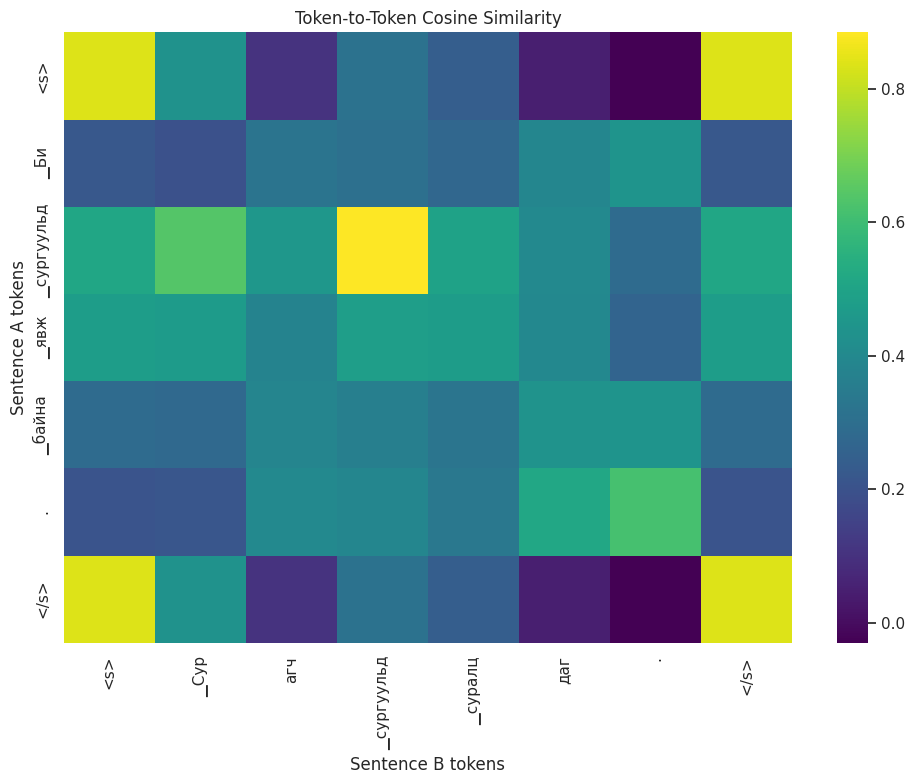

Similarity matrix shape: (7, 8)


In [19]:
def plot_token_similarity(emb1, tokens1, emb2, tokens2, figsize=(10,8), cmap="viridis"):
    # Compute cosine similarity matrix (seq_len1 x seq_len2)
    sim = cosine_similarity(emb1, emb2)  # shape (len(tokens1), len(tokens2))
    plt.figure(figsize=figsize)
    sns.heatmap(sim, xticklabels=tokens2, yticklabels=tokens1, cmap=cmap, annot=False)
    plt.title("Token-to-Token Cosine Similarity")
    plt.xlabel("Sentence B tokens")
    plt.ylabel("Sentence A tokens")
    plt.tight_layout()
    plt.show()
    return sim

sim_matrix = plot_token_similarity(emb_a, tokens_a, emb_b, tokens_b)
print("Similarity matrix shape:", sim_matrix.shape)


## Ignore special tokens & group subwords for word-level mapping

In [20]:
# Helper to drop special tokens (like [CLS], [SEP]) and group subwords to reconstruct word-level embeddings
def tokens_to_words(tokens):
    """
    Returns a tuple (word_list, token_index_groups)
    token_index_groups is a list of lists; each inner list indexes tokens belonging to that word.
    This tries to merge '##' subword tokens (WordPiece style) into single words.
    """
    words = []
    groups = []
    current = []
    current_word = ""
    for idx, t in enumerate(tokens):
        # skip special tokens
        if t in tokenizer.all_special_tokens:
            if current:
                groups.append(current)
                words.append(current_word)
                current, current_word = [], ""
            continue

        # WordPiece style: tokens that start with '##' are continuations
        if t.startswith("##"):
            current.append(idx)
            current_word += t.replace("##", "")
        else:
            if current:
                groups.append(current)
                words.append(current_word)
            current = [idx]
            current_word = t
    if current:
        groups.append(current)
        words.append(current_word)
    return words, groups

words_a, groups_a = tokens_to_words(tokens_a)
words_b, groups_b = tokens_to_words(tokens_b)

print("Words A:", words_a)
print("Groups A:", groups_a)
print("Words B:", words_b)
print("Groups B:", groups_b)


Words A: ['▁Би', '▁сургуульд', '▁явж', '▁байна', '.']
Groups A: [[1], [2], [3], [4], [5]]
Words B: ['▁Сур', 'агч', '▁сургуульд', '▁суралц', 'даг', '.']
Groups B: [[1], [2], [3], [4], [5], [6]]


## Aggregate token embeddings into word embeddings (mean pooling) & compute word-level similarity

Word embeddings shapes: (5, 384) (6, 384)


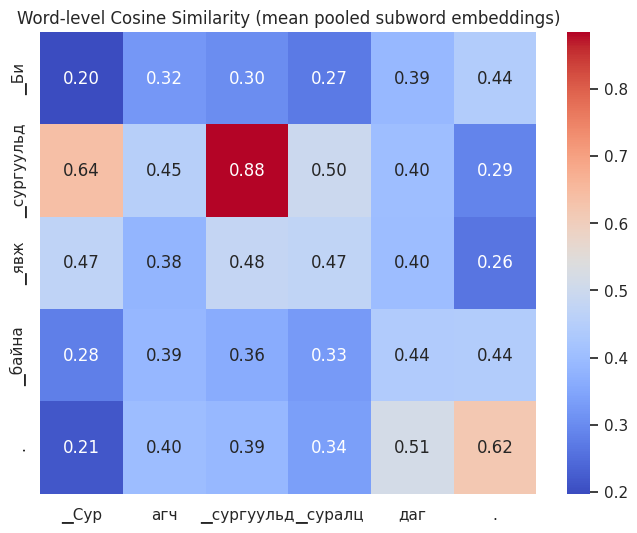

In [21]:
def aggregate_word_embeddings(token_embs, token_groups):
    """
    token_embs: numpy array (seq_len, dim)
    token_groups: list of lists of token indices per word
    returns: (num_words, dim)
    """
    word_embs = []
    for grp in token_groups:
        vecs = [token_embs[i] for i in grp]
        word_embs.append(np.mean(vecs, axis=0))
    return np.vstack(word_embs)

word_embs_a = aggregate_word_embeddings(emb_a, groups_a)
word_embs_b = aggregate_word_embeddings(emb_b, groups_b)

print("Word embeddings shapes:", word_embs_a.shape, word_embs_b.shape)

# Compute word-level similarity matrix
word_sim = cosine_similarity(word_embs_a, word_embs_b)
plt.figure(figsize=(8,6))
sns.heatmap(word_sim, xticklabels=words_b, yticklabels=words_a, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Word-level Cosine Similarity (mean pooled subword embeddings)")
plt.show()


## 2D Visualization (t-SNE)

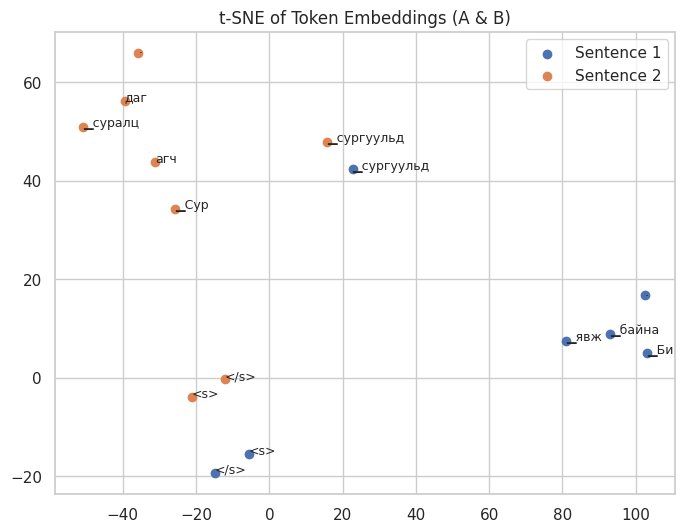

In [22]:
def plot_2d_tokens(embs_list, labels_list, title="2D token visualization (t-SNE)", perplexity=5):
    """
    embs_list: list of (N_i, dim) numpy arrays
    labels_list: list of token lists (strings)
    """
    # stack all token embs
    all_embs = np.vstack(embs_list)
    # reduce dimension
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, init='pca', learning_rate='auto')
    reduced = tsne.fit_transform(all_embs)
    # split back
    splits = np.cumsum([e.shape[0] for e in embs_list])[:-1]
    parts = np.split(reduced, splits)
    # plot
    plt.figure(figsize=(8,6))
    colors = ["C0","C1","C2","C3","C4"]
    for idx, part in enumerate(parts):
        xs, ys = part[:,0], part[:,1]
        plt.scatter(xs, ys, label=f"Sentence {idx+1}", color=colors[idx%len(colors)])
        for i, txt in enumerate(labels_list[idx]):
            plt.annotate(txt, (xs[i], ys[i]), fontsize=9)
    plt.legend()
    plt.title(title)
    plt.show()

# Use token-level embeddings and tokens (filter out special tokens if desired)
plot_2d_tokens([emb_a, emb_b], [tokens_a, tokens_b], title="t-SNE of Token Embeddings (A & B)", perplexity=3)
